<a href="https://colab.research.google.com/github/isshii/de4test/blob/master/LIME/DeepXplore_with_LIME_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 共通で使うパスなどの定義
# 共通の変数設定
# 共通フォルダパス
data_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data"
data_imagenet = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet"
data_imagenet_seeds = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds"
model_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/model"
output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output"
tmp_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/tmp"


In [7]:
# Goggle Drive つなぐ
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# outputフォルダ内容物のクリーンアップ削除
!rm "$output_dir"/*

In [8]:
import argparse

%tensorflow_version 1.x
from keras.applications.resnet50 import ResNet50
from keras.applications import vgg16 as vgg16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Input
import imageio


Using TensorFlow backend.


In [9]:
# Limeのインストール
%load_ext autoreload
%autoreload 2
import os,sys
! pip install lime


     |████████████████████████████████| 276kB 5.0MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=d6b1f2d6d80a1cc55b93e2e39d044ce71ec0eda4bc990718cae39a5a9d5be01c
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12073 sha256=d31afa31d78b2be45b2bffb8e1506f27c36cf5fe03cf11f1e025a4b4a62b8e4d
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [0]:
# Lime で利用するライブラリのインストール
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt


In [11]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3740043161421319879, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17689310518525182271
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12475337355684316681
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15977971536971904897
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [12]:
#@title デフォルトのタイトル テキスト
# DeepXplore のパラメータ設定部
# read the parameter
# argument parsing
parser = argparse.ArgumentParser(description='Main function for difference-inducing input generation in MNIST dataset')
parser.add_argument('transformation', help="realistic transformation type", choices=['light', 'occl', 'blackout'])
parser.add_argument('weight_diff', help="weight hyperparm to control differential behavior", type=float)
parser.add_argument('weight_nc', help="weight hyperparm to control neuron coverage", type=float)
parser.add_argument('step', help="step size of gradient descent", type=float)
parser.add_argument('seeds', help="number of seeds of input", type=int)
parser.add_argument('grad_iterations', help="number of iterations of gradient descent", type=int)
parser.add_argument('threshold', help="threshold for determining neuron activated", type=float)
parser.add_argument('-t', '--target_model', help="target model that we want it predicts differently",
                    choices=[0, 1, 2], default=0, type=int)
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(0, 0), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(10, 10), type=tuple)



_StoreAction(option_strings=['-occl_size', '--occlusion_size'], dest='occlusion_size', nargs=None, const=None, default=(10, 10), type=<class 'tuple'>, choices=None, help='occlusion size', metavar=None)

In [0]:
#@title ノイズのタイプ light / occl / blackout
#@body {light,occl,blackout} weight_diff weight_nc step seeds
#                   grad_iterations threshold
noise_type = "light" #@param ["light", "occl", "blackout"]
weight_diff = "0.1" #@param {type:"string"}
weight_nc = "0.1" #@param {type:"string"}
step = "1" #@param {type:"string"}
seeds = "10" #@param {type:"string"}
grad_iterations = "10" #@param {type:"string"}
threshold = "0.1" #@param {type:"string"}

In [0]:
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

In [0]:
import random
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image as k_image
import os, re


def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    input_img_data = image.img_to_array(img)
    input_img_data = np.expand_dims(input_img_data, axis=0)
    input_img_data = preprocess_input(input_img_data)  # final input shape = (1,224,224,3)
    return input_img_data


def deprocess_image(x):
    x = x.reshape((224, 224, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def decode_label(pred):
    return decode_predictions(pred)[0][0][1]


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def constraint_occl(gradients, start_point, rect_shape):
    new_grads = np.zeros_like(gradients)
    new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
    start_point[1]:start_point[1] + rect_shape[1]] = gradients[:, start_point[0]:start_point[0] + rect_shape[0],
                                                     start_point[1]:start_point[1] + rect_shape[1]]
    return new_grads


def constraint_light(gradients):
    new_grads = np.ones_like(gradients)
    grad_mean = 1e4 * np.mean(gradients)
    return grad_mean * new_grads


def constraint_black(gradients, rect_shape=(10, 10)):
    start_point = (
        random.randint(0, gradients.shape[1] - rect_shape[0]), random.randint(0, gradients.shape[2] - rect_shape[1]))
    new_grads = np.zeros_like(gradients)
    patch = gradients[:, start_point[0]:start_point[0] + rect_shape[0], start_point[1]:start_point[1] + rect_shape[1]]
    if np.mean(patch) < 0:
        new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
        start_point[1]:start_point[1] + rect_shape[1]] = -np.ones_like(patch)
    return new_grads


def init_coverage_tables(model1, model2, model3):
    model_layer_dict1 = defaultdict(bool)
    model_layer_dict2 = defaultdict(bool)
    model_layer_dict3 = defaultdict(bool)
    init_dict(model1, model_layer_dict1)
    init_dict(model2, model_layer_dict2)
    init_dict(model3, model_layer_dict3)
    return model_layer_dict1, model_layer_dict2, model_layer_dict3


def init_dict(model, model_layer_dict):
    for layer in model.layers:
        if 'flatten' in layer.name or 'input' in layer.name:
            continue
        for index in range(layer.output_shape[-1]):
            model_layer_dict[(layer.name, index)] = False


def neuron_to_cover(model_layer_dict):
    not_covered = [(layer_name, index) for (layer_name, index), v in list(model_layer_dict.items()) if not v]
    if not_covered:
        layer_name, index = random.choice(not_covered)
    else:
        layer_name, index = random.choice(list(model_layer_dict.keys()))
    return layer_name, index


def neuron_covered(model_layer_dict):
    covered_neurons = len([v for v in list(model_layer_dict.values()) if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)


def scale(intermediate_layer_output, rmax=1, rmin=0):
    X_std = (intermediate_layer_output - intermediate_layer_output.min()) / (
        intermediate_layer_output.max() - intermediate_layer_output.min())
    X_scaled = X_std * (rmax - rmin) + rmin
    return X_scaled


def update_coverage(input_data, model, model_layer_dict, threshold=0):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)

    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        for num_neuron in range(scaled.shape[-1]):
            if np.mean(scaled[..., num_neuron]) > threshold and not model_layer_dict[(layer_names[i], num_neuron)]:
                model_layer_dict[(layer_names[i], num_neuron)] = True


def full_coverage(model_layer_dict):
    if False in list(model_layer_dict.values()):
        return False
    return True


def fired(model, layer_name, index, input_data, threshold=0):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_layer_output = intermediate_layer_model.predict(input_data)[0]
    scaled = scale(intermediate_layer_output)
    if np.mean(scaled[..., index]) > threshold:
        return True
    return False


def diverged(predictions1, predictions2, predictions3, target):
    if not predictions1 == predictions2 == predictions3:
        return True
    return False

#add
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

In [0]:
# lime params
label_cnt = 5 #@param{type:"integer"}
sample_count = 1000 #@param
is_positive = False #@param{type:"boolean"}


In [0]:
# lime funtion
def explain(image, model):
  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(image, model.predict, top_labels=label_cnt, hide_color=0, num_samples=1000)
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=is_positive, num_features=5, hide_rest=False)
  plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


In [18]:
%%time
# input image dimensions
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

# define input tensor as a placeholder
input_tensor = Input(shape=input_shape)

# load multiple models sharing same input tensor
K.set_learning_phase(0)
model1 = VGG16(input_tensor=input_tensor)
model2 = VGG19(input_tensor=input_tensor)
model3 = ResNet50(input_tensor=input_tensor)


# init coverage table
model_layer_dict1, model_layer_dict2, model_layer_dict3 = init_coverage_tables(model1, model2, model3)





553467904/553467096 [==============================] - 12s 0us/step






574717952/574710816 [==============================] - 12s 0us/step


102858752/102853048 [==============================] - 3s 0us/step
CPU times: user 9.95 s, sys: 3.74 s, total: 13.7 s
Wall time: 43 s


In [19]:
# start gen inputs
 img_paths = list_pictures(data_imagenet_seeds)
 print(img_paths)


['/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00001907.JPEG', '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00001823.JPEG', '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00001880.JPEG', '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00001855.JPEG', '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00001993.JPEG', '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00001819.JPEG', '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00001950.JPEG', '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00001822.JPEG', '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00002002.JPEG', '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/ILSVRC2012_test_00001

In [16]:
%%time
for _ in range(args.seeds):
    gen_img = preprocess_image(random.choice(img_paths))
    orig_img = gen_img.copy()
    # first check if input already induces differences
    pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
    label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])
    if not label1 == label2 == label3:
        print('input already causes different outputs: {}, {}, {}'.format(decode_label(pred1),
                                                                                            decode_label(pred2),
                                                                                            decode_label(
                                                                                                pred3)))

        update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
        update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
        update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

        print('covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
              % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                 neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                 neuron_covered(model_layer_dict3)[2]))
  
        averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                       neuron_covered(model_layer_dict3)[0]) / float(
            neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
            neuron_covered(model_layer_dict3)[1])
        print('averaged covered neurons %.3f' % averaged_nc)

        gen_img_deprocessed = deprocess_image(gen_img)

        # save the result to disk
        outputfilepath0 = os.path.join(output_dir, 'already_differ_' + decode_label(pred1) + '_' + decode_label(pred2) + '_' + decode_label(pred3) + '.png')
        imageio.imwrite(outputfilepath0, gen_img_deprocessed)
        continue

    # if all label agrees
    orig_label = label1
    layer_name1, index1 = neuron_to_cover(model_layer_dict1)
    layer_name2, index2 = neuron_to_cover(model_layer_dict2)
    layer_name3, index3 = neuron_to_cover(model_layer_dict3)

    # construct joint loss function
    if args.target_model == 0:
        loss1 = -args.weight_diff * K.mean(model1.get_layer('predictions').output[..., orig_label])
        loss2 = K.mean(model2.get_layer('predictions').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('fc1000').output[..., orig_label])
    elif args.target_model == 1:
        loss1 = K.mean(model1.get_layer('predictions').output[..., orig_label])
        loss2 = -args.weight_diff * K.mean(model2.get_layer('predictions').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('fc1000').output[..., orig_label])
    elif args.target_model == 2:
        loss1 = K.mean(model1.get_layer('predictions').output[..., label1])
        loss2 = K.mean(model2.get_layer('predictions').output[..., orig_label])
        loss3 = -args.weight_diff * K.mean(model3.get_layer('fc1000').output[..., orig_label])
    loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
    loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
    loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
    layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)

    # for adversarial image generation
    final_loss = K.mean(layer_output)

    # we compute the gradient of the input picture wrt this loss
    grads = normalize(K.gradients(final_loss, input_tensor)[0])

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])
    print("+++++++++")
    print(grads)
    print(input_tensor)
    print(loss1)
    print(loss1_neuron)
    print(loss2)
    print(loss2_neuron)
    print(loss3)
    print(loss3_neuron)
    print("+++++++++")
    print(gen_img.shape)
    # we run gradient ascent for 20 steps
    for iters in range(args.grad_iterations):
        loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate(
            [gen_img])
        if args.transformation == 'light':
            grads_value = constraint_light(grads_value)  # constraint the gradients value
        elif args.transformation == 'occl':
            grads_value = constraint_occl(grads_value, args.start_point,
                                          args.occlusion_size)  # constraint the gradients value
        elif args.transformation == 'blackout':
            grads_value = constraint_black(grads_value)  # constraint the gradients value

        gen_img += grads_value * args.step
        pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
        label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

        if not label1 == label2 == label3:
            update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
            update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
            update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
            averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                           neuron_covered(model_layer_dict3)[0]) / float(
                neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
                neuron_covered(model_layer_dict3)[
                    1])
            print('averaged covered neurons %.3f' % averaged_nc)

            gen_img_deprocessed = deprocess_image(gen_img)
            orig_img_deprocessed = deprocess_image(orig_img)

            # save the result to disk
            outputfilepath = os.path.join(output_dir, args.transformation + '_' + decode_label(pred1) + '_' + decode_label(pred2) + '_' + decode_label(pred3) + '.png')
            print(outputfilepath)
            imageio.imwrite(outputfilepath, gen_img_deprocessed)
            outputfilepath2 = os.path.join(output_dir, args.transformation + '_' + decode_label(pred1) + '_' + decode_label(pred2) + '_' + decode_label(pred3) + '_orig.png')
            print(outputfilepath2)
            imageio.imwrite(outputfilepath2, orig_img_deprocessed)
            break

40960/35363 [==================================] - 0s 0us/step
input already causes different outputs: Border_terrier, wallaby, dingo
covered neurons percentage 14888 neurons 0.117, 16168 neurons 0.108, 94123 neurons 0.743
averaged covered neurons 0.586
+++++++++
Tensor("truediv:0", shape=(?, 224, 224, 3), dtype=float32)
Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32)
Tensor("mul:0", shape=(), dtype=float32)
Tensor("Mean_3:0", shape=(), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)
Tensor("Mean_4:0", shape=(), dtype=float32)
Tensor("Mean_2:0", shape=(), dtype=float32)
Tensor("Mean_5:0", shape=(), dtype=float32)
+++++++++
(1, 224, 224, 3)
input already causes different outputs: ground_beetle, long-horned_beetle, long-horned_beetle
covered neurons percentage 14888 neurons 0.208, 16168 neurons 0.188, 94123 neurons 0.752
averaged covered neurons 0.615
+++++++++
Tensor("truediv_1:0", shape=(?, 224, 224, 3), dtype=float32)
Tensor("input_1:0", shape=(?, 224, 224, 3), d

In [0]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
#        img = image.load_img(img_path, target_size=(299, 299))
        print(img_path)
        img = k_image.load_img(img_path, target_size=(224, 224))
        print("in here")
        plt.imshow(img)
        x = k_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
#        x = inc_net.preprocess_input(x)
#        x = vgg16.preprocess_input(x,mode='tf')
        x = vgg16.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

['/content/gdrive/My Drive/ColabNotebooks/test4ai/output/already_differ_Border_terrier_wallaby_dingo.png', '/content/gdrive/My Drive/ColabNotebooks/test4ai/output/light_toilet_seat_toilet_seat_lighter.png', '/content/gdrive/My Drive/ColabNotebooks/test4ai/output/light_toilet_seat_toilet_seat_lighter_orig.png', '/content/gdrive/My Drive/ColabNotebooks/test4ai/output/light_flamingo_flamingo_web_site.png', '/content/gdrive/My Drive/ColabNotebooks/test4ai/output/light_flamingo_flamingo_web_site_orig.png', '/content/gdrive/My Drive/ColabNotebooks/test4ai/output/test.png', '/content/gdrive/My Drive/ColabNotebooks/test4ai/output/test_org.png']
/content/gdrive/My Drive/ColabNotebooks/test4ai/output/test_org.png
in here
==== explain model 1 ====



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


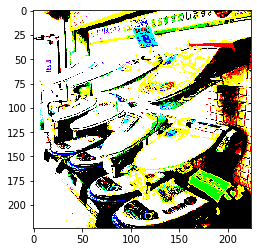

In [21]:
generagte_img_paths = list_pictures(output_dir)
print(generagte_img_paths)
pre_image = random.choice(generagte_img_paths)
# images = transform_img_fn(output_dir+"/")
images = transform_img_fn([os.path.join(output_dir,'test_org.png')])

for image in images:
    # gen_img じゃなくてGenerated Imgを利用するように変更する
    print("==== explain model 1 ====")
    explain(image, model1)

==== explain model 2 ====



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


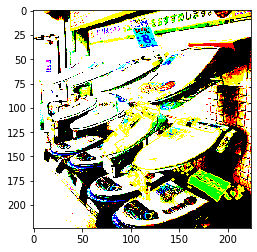

In [22]:
for image in images:
    print("==== explain model 2 ====")
    explain(image, model2)


==== explain model 3 ====



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


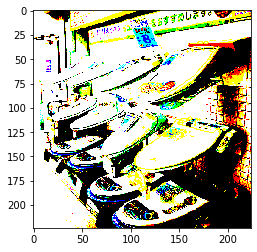

In [23]:
for image in images:
    print("==== explain model 3 ====")
    explain(image, model3)
